# Generative Adversarial Networks (GANs): Introduction & MNIST Generation

I made these notes following the course by J.M. Portilla ['Complete Tensorflow 2 and Keras Deep Learning Bootcamp'](https://www.udemy.com/course/complete-tensorflow-2-and-keras-deep-learning-bootcamp/) and the following video by Luis Serrano:

[A Friendly Introduction to Generative Adversarial Networks (GANs)](https://www.youtube.com/watch?v=8L11aMN5KY8).

Generative Adversarial Networks (GANs) were introduced by Ian Goodfellow and colleagues in 2014.
They consist of two networks that compete with each other:
- The **Generator** `G()` network learns to generate fake but realistic/meaningful data from a `z` noise input. Its output is of the size of a data sample (often an image).
- The **Discriminator** `D()` network learns to distinguish between fake and real data. Its output is 1 (real) or 0 (fake).

Some notes on the notation:
- The noise is `z` (Gaussian).
- The Generator produces `G(z)`.
- The discriminator takes that `G(z)` as fake input (as well as real samples) and produces `D(G(z))`, which should be real (1) even for fake (0) samples (e.g., images) at the end.

The final goal of a GAN is to train both networks together as if they are competing; then, **the resulting Generator G() is able to create very realistic fake data (e.g., face images)**.

To that end, the training works in two Phases (for each epoch) which can be repeated one after the other several times or with each batch (for some epochs):
- Phase 1: The Discriminator is trained to distinguish fake vs real
    - We generate a dataset of real images labelled as 1 and fake images generated by the Generator (with `z` noise inputs) labelled as 0.
    - The binary classification Discriminator is trained: first real samples can be used for N epochs, then fake samples.
    - Backpropagation and weight update occurs on the Discriminator.
    - As a result, the Discriminator learns to distinguish fake vs real.
- Phase 2: The Generator is trained to fool the Discriminator
    - We produce more fake images with `G()` and feed them to the Discriminator `D()` **but labelled as 1 (real)**.
    - We have a fake sample labelled as real: `D(G(z))` will probably yield something close to 'fake' or `0`, but we expect `1` or 'real'; we compute our loss according to our expectation and use it to update the weights of the Generator.
    - Backpropagation and weight update occurs on the Generator.
    - As a result, the Generator is trained to produce realistic fake samples that are classified as real by the Discriminator after a successful training.

While training phases continue one after the other, both the Generator and Discriminator get better at their jobs.

Note that **the Generator never sees a real image!** Instead it learns from the gradients of the discriminator; the most performant the discriminator, the more information it collects in its gradients.

**Figure 1: Discriminator D() fed by fake images by the Generator G()**: A noise input `z` is used to generate a fake sample; then, that fake sample is fed to a Discriminator. Credits by Luis Serrano (see link above).
![Discriminator D() fed by fake images by the Generator G()](./pics/GAN_LuisSerrano_Fake.png)

**Figure 2: Discriminator D() fed with real images**: A real image is fed to Discriminator. Credits by Luis Serrano (see link above).
![Discriminator D() fed with real images](./pics/GAN_LuisSerrano_Real.png)

**Figure 3: Phase 2: Discriminator D() fed by fake images from the Generator G(), but fooled to expect real samples**: The loss function applied to the Generator is `-ln(D(G(z)))`. Credits by Luis Serrano (see link above).
![Discriminator D() fed by fake images by the Generator G()](./pics/GAN_LuisSerrano_Training_Error.png)

### Difficulties with GANs

**Training resources**: GANs are often used for images; training on them requires powerful GPUs. We could use Gooogle Colab, since it offers GPUs for free.

**Mode collapse**: The Generator ends up producing a single image that always fools the Discriminator, independently of the noise input. See this [Quora link](https://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same). There are several approaches to overcome the issue:
- Deep Convolutional GANs (DCGANs).
- Mini-batch discrimination: generated batches that contain similar images are punished.

**Instability**: It is sometimes difficult to evaluate performance and decide the necessary epochs, since all our images are fake. Additionally, since both `G()` and `D()` are competing, their performance score might start oscillating, which is not desired. Therefore, hyperparameter tuning is essential.

### Relationship between Autoencoders and GANs (my personal interpretation)

The Generator of a GAN is very similar to the Decoder of an Autoencoder.
A Decoder gets as input a vector from a latent space and it expands it.
The Generator gets a random vector and creates a meaningful image from it.
Thus, an interpretation of what we do with GANs is that **we train the Generator to create a valid latent space which is expanded to meaningful images/data; then, we take a random vector from the latent space and we expand it.**

### Considerations for Implementation

The model is built as a concatenation of the Generator and the Discriminator: `GAN = Sequential([generator,discriminator])`.
Addditionally, each of the parts is defined as a `Sequential()`:
- `generator` expands from the latent space to the image space
- `discriminator` condenses the image to a binary classificator

Notes on the definitions of the loss functions:
- the `discriminator` sub-model has binary cross-entropy loss function
- the `generator` sub-model has **no loss function**, because it is used attached to the `discriminator` in the complete `GAN` model
- the complete `GAN` model has also another binary cross-entropy loss function

Therefore:
- When the `discriminator` is trained (Phase 1), its own loss function is used and the optimization happens in is weights
- When the `generator` is trained (Phase 2), the `discriminator` must be set as `not trainable`; the used loss function is the one of the complete `GAN`. That means, the weights of both submodels are considered to update only the weights of the `generator`.

## Analysis of Loss Functions

This is a very simple section in which I plot the loss functions of the Generator and the Discriminator. Recall that in the Phase 2 we feed fake samples to the Discriminator labelled as real.

The loss function `-ln(x)` performs an inverse mapping: small `x` values (close to 0) become large ones and large `x` values (close to 1) become small ones.

Thus, when the Discriminator determines that the fake sample is fake (against its label), the loss applied to the Generator is big; otherwise, the loss is small.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Discriminator')

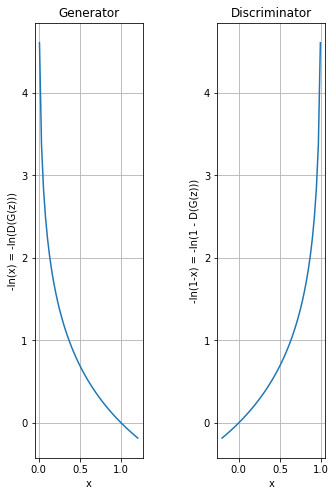

In [2]:
# Both loss functions are plotted
fig = plt.figure(figsize=(6,8))
sub1 = fig.add_subplot(1,2,1)
x = np.linspace(0.01,1.2,50)
y = -np.log(x)
sub1.plot(x,y)
sub1.grid(True)
sub1.set_aspect('equal','box')
sub1.set_xlabel('x')
sub1.set_ylabel('-ln(x) = -ln(D(G(z)))')
sub1.set_title('Generator')
sub2 = fig.add_subplot(1,2,2)
x = np.linspace(-0.2,0.99,50)
y = -np.log(1-x)
sub2.plot(x,y)
sub2.grid(True)
sub2.set_aspect('equal','box')
sub2.set_xlabel('x')
sub2.set_ylabel('-ln(1-x) = -ln(1 - D(G(z)))')
sub2.set_title('Discriminator')

## Exmaple with the MNIST Dataset

### Dataset

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
from tensorflow.keras.datasets import mnist

In [138]:
(X_train,y_train), (X_test,y_test) = mnist.load_data()

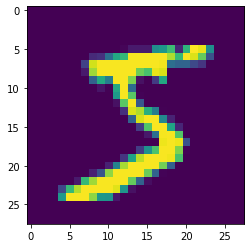

In [139]:
plt.imshow(X_train[0])

In [140]:
# We take only images with 0 numbers to make it easier and faster - the goal is to learn
# Also, the number 0 is quite distinct
# However, we could choose any number
number = 0
only_zeros = X_train[y_train==number]

In [141]:
only_zeros.shape

(5923, 28, 28)

In [142]:
X_train.shape

(60000, 28, 28)

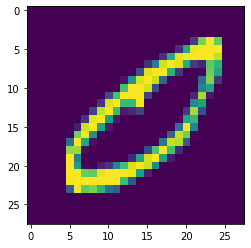

In [143]:
plt.imshow(only_zeros[101])

### GAN Model

In [174]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Flatten
from tensorflow.keras.models import Sequential

In [175]:
only_zeros.shape

(5923, 28, 28)

In [176]:
28*28

784

In [177]:
# Discriminator: Given a fake/real image, it yields prob of fake/real
# Thus, we go from 28x28 to 1
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28,28]))
#discriminator.add(Dense(350,activation='relu'))
discriminator.add(Dense(150,activation='relu'))
discriminator.add(Dense(100,activation='relu'))
# Final output layer
discriminator.add(Dense(1,activation="sigmoid"))
# Compile with binary cross-entropy loss (because we expect 0/1)
discriminator.compile(loss='binary_crossentropy',optmizer='adam')

In [178]:
# Generator:
# Taking noise as input, it creates fake images which should become as realistic as possible
# The generator is very similar to the decoder in an autoencoder:
# we need to select a valid sice of the noise vector
# in the same way the size of the latent space was relevant to expand compressed data.
# In other words: We basically create random vectors in the latent space!
# And the network learns to create a valid latent space so that the images are realistic
#
# We need to choose a valid size of the latent space
# 28x28 = 784 -> (350) -> 150 -> 100
coding_size = 100
generator = Sequential()
generator.add(Dense(100,activation='relu',input_shape=[coding_size]))
generator.add(Dense(150,activation='relu'))
generator.add(Dense(350,activation='relu'))
generator.add(Dense(784,activation='relu'))
generator.add(Reshape([28,28]))

In [179]:
GAN = Sequential([generator,discriminator])

Both models (Generator & Discriminator) are trained together in competition and in two different phases.
Thus, it is not possible to use the usual `model.fit()` procedure.
Instead, we need to write our own training loop.
Additionally, note that:
- A model can be set to not be trained with `.trainable = False`
- We do not compile the Generator with a loss function; instead we compile the complete GAN
- The GAN joint model itself is a binary classificator
- In order to compile the GAN, we need to make `discriminator.trainable = False`

In [180]:
# To compile the complete GAN, we need to switch off the trainability of the discriminator
discriminator.trainable = False

In [181]:
GAN.compile(loss='binary_crossentropy',optimizer='adam')

### Dataset Preparation: Batches

In [182]:
batch_size = 32

In [183]:
#my_data = X_train
my_data = only_zeros

In [184]:
# Create a shuffled dataset generator
# buffer_size value is typically 1000: every that number smaples are shuffled
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [185]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [186]:
# Create batches; drop_remainder cuts off last batch with less samples
# I think .prefetch(1) is optional
# I understand it parallelizes data fetching and processing for better performance
dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)

In [187]:
# We create 185 batches of 32 samples each; rest is dropped
my_data.shape[0]/batch_size

185.09375

### Model/Layer Access

We can access the "sub-models" and their layers with `.layers`; note that there are no "sub-models", but only collections of `Sequential` objects.

In [188]:
# See different objects within GAN
GAN.layers

In [189]:
# See layers of first object within GAN
GAN.layers[0].layers

In [190]:
# Summary of our Generator model
# Analogously, we can apply any other function that our model/object accepts
GAN.layers[0].summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_59 (Dense)             (None, 150)               15150     
_________________________________________________________________
dense_60 (Dense)             (None, 350)               52850     
_________________________________________________________________
dense_61 (Dense)             (None, 784)               275184    
_________________________________________________________________
reshape_5 (Reshape)          (None, 28, 28)            0         
Total params: 353,284
Trainable params: 353,284
Non-trainable params: 0
_________________________________________________________________


### Training Function

In [191]:
# Unpack the GAN models
generator, discriminator = GAN.layers

In [192]:
epochs = 2

In [193]:
for epoch in range(epochs):
    print(f"Currently in Epoch {epoch+1}")
    # Batch counter/tracker
    i = 0
    for X_batch in dataset:
        # Batch counter
        i = i + 1
        if i%50 == 0:
            print(f"\tCurrently in Batch {i} of {len(my_data)//batch_size}")
            
        # Phase 1: DISCRIMINATOR TRAINING
        # We create the latent noise vector: batch x latent space
        noise = tf.random.normal(shape=[batch_size,coding_size])
        # Feed the Generator with the noise vector to generate images
        gen_images = generator(noise)
        # Conocatenate fake & real images
        # We need to cast our real images
        X_fake_vs_real = tf.concat([gen_images,tf.dtypes.cast(X_batch,tf.float32)],axis=0)
        # Set target label
        # We expand lists of 0.0 and 1.0 elements and concatenate them
        # We do that regardless on how many classes we have!
        y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)
        # We make the Discriminator trainable
        # It was not trainable in order to compile the GAN above
        discriminator.trainable = True
        # Train one batch
        discriminator.train_on_batch(X_fake_vs_real,y1)
        
        # Phase 2: GENERATOR TRAINING
        # Create latent noise, as before
        noise = tf.random.normal(shape=[batch_size,coding_size])
        # We create FAKE images, but LABEL THEM AS REAL
        y2 = tf.constant([[1.0]]*batch_size)
        # Switch off Dirscriminator training
        discriminator.trainable = False
        # Train complete GAN on the batch:
        # noise fed to Generator -> 
        # output to Discriminator ->
        # custom ground truth (real but fake) used to compute loss
        GAN.train_on_batch(noise,y2)

print("Training Complete!")

Currently in Epoch 1
	Currently in Batch 50 of 185
	Currently in Batch 100 of 185
	Currently in Batch 150 of 185
Currently in Epoch 2
	Currently in Batch 50 of 185
	Currently in Batch 100 of 185
	Currently in Batch 150 of 185
Training Complete!


### Inference

Now we create 10 random vectors and feed them to the generator to create artificial images (of the number we selected).

**NOTE: Unfortunately, I got noisy images and mode collapse...NOTE: Unfortunately, I got noisy images and mode collapse..**

In [202]:
noise = tf.random.normal(shape=[10,coding_size])

In [203]:
noise.shape

TensorShape([10, 100])

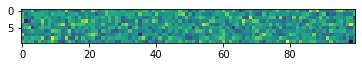

In [204]:
# Plot the 10 noise vectors
plt.imshow(noise)

In [205]:
# Inference
images = generator(noise)

In [206]:
images.shape

TensorShape([10, 28, 28])

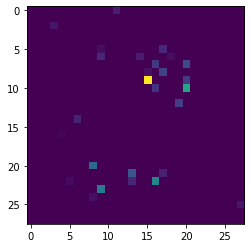

In [208]:
plt.imshow(images[3])

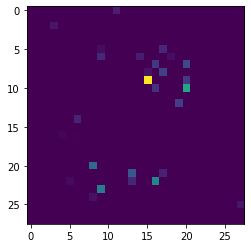

In [210]:
# We have mode collapse
plt.imshow(images[5])